In [ ]:
# Business Problem

# Amazon üzerinden satışlarını gerçekleştiren ev tesktili ve günlük giyim odaklı üretimler yapan Kozmos ürünlerine gelen yorumları analiz ederek ve aldığı şikayetlere göre özelliklerini geliştirerek satışlarını artırmayı hedeflemektedir.Bu hedef doğrultusunda yorumlara duygu analizi yapılarak etiketlencek ve etiketlenen veri ile sınıflandırma modeli oluşturulacaktır.


# Veri Seti Hikayesi

# Veri seti belirli bir ürün grubuna ait yapılan yorumları, yorum başlığını, yıldız sayısını ve yapılan yorumu kaç kişinin faydalı bulduğunu belirten değişkenlerden oluşmaktadır.

# Review: Ürüne yapılan yorum
# Title: Yorum içeriğine verilen başlık, kısa yorum
# HelpFul: Yorumu faydalı bulan kişi sayısı
# Star: Ürüne verilen yıldız sayısı

In [3]:

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)

Metin ön işleme işlemleri.

In [13]:
df = pd.read_excel("amazon.xlsx")
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [14]:
# eksik veri kontrolü

print(df.isnull().sum())
print(df.info())

Star        0
HelpFul     0
Title      52
Review     18
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB
None


In [15]:
df = df.dropna()
df.isnull().sum()

Star       0
HelpFul    0
Title      0
Review     0
dtype: int64

In [16]:
# •	Büyük küçük harf dönüşümü
# •	Noktalama işaretlerin çıkarılması
# •	Numerik ifadelerin çıkarılması

def clean_text(text):
    # Normalizing Case Folding
    text = text.str.lower()
    # Punctuations
    text = text.str.replace(r'[^\w\s]', '')
    text = text.str.replace("\n" , '')
    # Numbers
    text = text.str.replace('\d', '')
    return text

df["Review"] = clean_text(df["Review"])

df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,happy with it
1,5,0,Pattern did not align between the two panels.,good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,product was fun for bedroom windows.<br />imag...
3,5,0,Que se ven elegantes muy finas,lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,great bang for the buck i can't believe the qu...


In [18]:
# Metin içinde öznitelik çıkarımı yaparken önemli olmayan kelimelerin çıkarılması

def remove_stopwords(text):
    stop_words = stopwords.words('English')
    text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))
    return text

df["Review"] = remove_stopwords(df["Review"])
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,happy
1,5,0,Pattern did not align between the two panels.,good quality material however panels mis-matched.
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windows.<br />imagery bit ...
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria es que sean un poco mas ...
4,5,0,Wow great purchase,great bang buck can't believe quality material...


In [20]:
# Metinde az tekrarlayan kelimeleri bulunuz.

pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]

pretty!!         1
basketball.      1
boyfriends       1
separator.       1
bulk.            1
                ..
(cold            1
states,          1
glare.           1
dampish.         1
studio/living    1
Name: count, Length: 1000, dtype: int64

In [21]:
# Metinde az tekrarlayan kelimeleri metin içerisinden çıkartınız.

sil = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]

df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

In [22]:
# Metinleri tokenize edip sonuçları gözlemleyiniz.

df["Review"].apply(lambda x: TextBlob(x).words)

0                                                 [happy]
1       [good, quality, material, however, panels, mis...
2       [product, fun, bedroom, windows, br, imagery, ...
3       [lo, unico, que, gustaria, es, que, sean, un, ...
4       [great, bang, buck, ca, n't, believe, quality,...
                              ...                        
5606    [great, product, reasonable, money, delivered,...
5607                          [color, way, panels, match]
5608    [great, studio, complement, entire, theme, are...
5609              [brought, beauty, kids, room, love, it]
5610    [cute, curtains, sons, room, thick, enough, ke...
Name: Review, Length: 5550, dtype: object

In [23]:
# Lemmatization işlemini yapınız. (normalleştirme)

df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,happy
1,5,0,Pattern did not align between the two panels.,good quality material however panel mis-matched.
2,5,0,Imagery is stretched. Still fun.,product fun bedroom windows.<br />imagery bit ...
3,5,0,Que se ven elegantes muy finas,lo unico que gustaria e que sean un poco ma la...
4,5,0,Wow great purchase,great bang buck can't believe quality material...


In [24]:
# Metindeki terimlerin frekanslarını hesaplayınız. (Barplot grafiği için gerekli)

tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.head()


,index,0
0,happy,171.00
1,good,447.00
2,quality,602.00
3,material,395.00
4,however,36.00


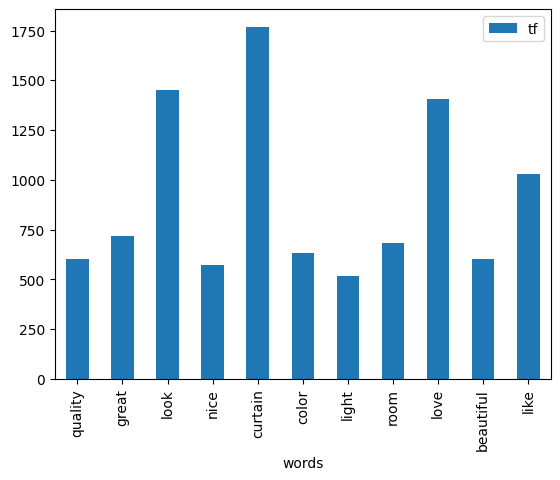

In [27]:
# Barplot grafiğini oluşturunuz.

# Sütunların isimlendirilmesi
tf.columns = ["words", "tf"]
# 500'den fazla geçen kelimelerin görselleştirilmesi
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

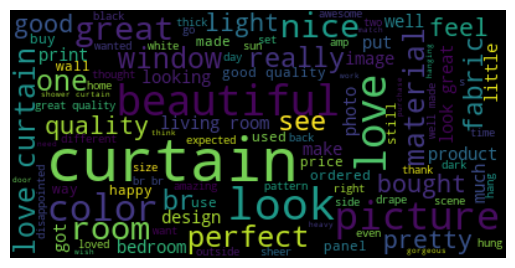

In [29]:
# Kelimeleri WordCloud ile görselleştiriniz.

# kelimeleri birleştirdik
text = " ".join(i for i in df["Review"])

# wordcloud görselleştirmenin özelliklerini belirliyoruz
wordcloud = WordCloud(max_font_size=50,
max_words=100,
background_color="black").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Duygu Analizi

In [37]:
sia = SentimentIntensityAnalyzer()

# Belirli bir sütundaki ilk 10 satırdaki metinleri kullanarak her bir metnin duygusal yoğunluğunu hesaplama
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

# Belirli bir sütundaki ilk 10 satırdaki metinlerin bileşik (compound) duygusal yoğunluk skorlarını alma
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

# Belirli bir sütundaki ilk 10 satırdaki metinlere göre pozitif veya negatif etiketler ekleyerek duygusal etiketleme
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

# Tüm veri çerçevesine bir "label" sütunu ekleyerek her metne göre pozitif veya negatif etiketler ekleyerek duygusal etiketleme
df["label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

# label sütununa göre gruplandırma yaparak her etiketin ortalama duygusal yoğunluğunu hesaplama
#df.groupby("label")["Star"].mean()


# NOT:SentimentIntensityAnalyzer ile yorumları etiketleyerek, yorum sınıflandırma makine öğrenmesi modeli için bağımlı değişken oluşturulmuş oldu.

Makine öğrenmesine hazırlık!

In [38]:
# Bağımlı ve bağımsız değişkenlerimizi belirleyerek datayı train test olara ayırınız.
# Test-Train
x_train, x_test, y_train, y_test = train_test_split(df["Review"],df["label"],random_state=42)

In [39]:
# Makine öğrenmesi modeline verileri verebilmemiz için temsil şekillerini sayısala çevirmemiz gerekmekte.
           # a. TfidfVectorizer veya CountVectorizer kullanarak bir nesne oluşturunuz.
           # b. Daha önce ayırmış olduğumuz train datamızı kullanarak oluşturduğumuz nesneye fit ediniz.
           # c. Oluşturmuş olduğumuz vektörü train ve test datalarına transform işlemini uygulayıp kaydediniz.

# TfidfVectorizer kullannarak
tf_idf_word_vectorizer = TfidfVectorizer().fit(x_train)
x_train = tf_idf_word_vectorizer.transform(x_train)
x_test = tf_idf_word_vectorizer.transform(x_test)

# CountVectorizer kullanarak
# count_vec = CountVectorizer()
# x_train = count_vec.fit_transform(x_train)
# x_test = count_vec.transform(x_test)


In [42]:
# modeli kurarak train dataları ile fit ediniz.

model = MultinomialNB()
#model = SVC()
#model = RandomForestClassifier() 
#model = LogisticRegression()

model_fit = model.fit(x_train, y_train)

# Test verilerini kullanarak tahmin yapın
y_pred = model_fit.predict(x_test)

score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(score)
print(cm)


0.888328530259366
[[  19  155]
 [   0 1214]]


In [45]:
# Çapraz doğrulama skorunu hesaplayın ve yazdırın
cross_val_mean = cross_val_score(model, x_test, y_test, cv=5, n_jobs=-1).mean()
print("Cross-Validation Score:", cross_val_mean)

Cross-Validation Score: 0.8775238293120017
